In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Hyperparameters and configuration
NUM_MODALITIES = 4                    # e.g., profile, content, friending, engagement
FEATURE_DIMS = [32, 64, 16, 16]       # Input dimensions per modality
LINK_FEATURE_DIM = 8                  # Dimension of pairwise link features
HIDDEN_DIM = 64                       # Hidden layer dimension
OUTPUT_DIM = 32                       # Output (embedding) dimension per modality
NUM_LAYERS = 2                        # Number of message-passing layers
MARGIN = 0.1                          # Margin for ranking loss


In [59]:
class ModalityAggregator(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, link_feat_dim):
        super(ModalityAggregator, self).__init__()
        # Transform self features for attention computation
        self.W1 = nn.Linear(in_dim, hidden_dim)
        # Transform neighbor features
        self.W2 = nn.Linear(in_dim, out_dim)
        # Transform link (communication) features
        self.W_link = nn.Linear(link_feat_dim, out_dim)
        # Self connection transformation (used twice)
        self.self_fc = nn.Linear(in_dim, out_dim)
        # Attention layer: takes concatenated [self, neighbor] message
        self.attn_fc = nn.Linear(2 * out_dim, 1)
        # Final combination: fusing aggregated neighbor info with self connection
        self.fc_combine = nn.Linear(2 * out_dim, out_dim)
        self.leaky_relu = nn.LeakyReLU(0.2)
    
    def forward(self, self_feat, neighbor_feats, neighbor_link_feats):
        # self_feat: (B, in_dim)
        # neighbor_feats: (B, N, in_dim)
        # neighbor_link_feats: (B, N, link_feat_dim)
        
        # Transform self features (for attention)
        self_hidden = self.W1(self_feat)  # (B, hidden_dim)
        
        # Transform neighbor features and link features separately
        neighbor_transformed = self.W2(neighbor_feats)          # (B, N, out_dim)
        link_transformed     = self.W_link(neighbor_link_feats)   # (B, N, out_dim)
        messages = neighbor_transformed + link_transformed        # (B, N, out_dim)
        
        # Compute self features for attention
        self_for_attn = self.self_fc(self_feat)   # (B, out_dim)
        # Expand to match neighbor dimension (B, N, out_dim)
        self_for_attn_expanded = self_for_attn.unsqueeze(1).expand_as(messages)
        
        # Concatenate along the feature dimension
        attn_input = torch.cat([self_for_attn_expanded, messages], dim=-1)  # (B, N, 2*out_dim)
        # Debug: Uncomment to check shape
        # print("attn_input shape:", attn_input.shape)
        attn_scores = self.leaky_relu(self.attn_fc(attn_input))  # (B, N, 1)
        attn_scores = attn_scores.squeeze(-1)                    # (B, N)
        attn_weights = F.softmax(attn_scores, dim=-1)             # (B, N)
        
        # Aggregate neighbor messages using the attention weights
        aggregated = torch.sum(messages * attn_weights.unsqueeze(-1), dim=1)  # (B, out_dim)
        
        # Compute self-connection (again using self.self_fc)
        self_connection = self.self_fc(self_feat)              # (B, out_dim)
        
        # Concatenate aggregated and self connection features
        combined = torch.cat([aggregated, self_connection], dim=-1)  # (B, 2*out_dim)
        # Debug: Uncomment to check shape
        # print("combined shape:", combined.shape)
        out = F.elu(self.fc_combine(combined))                 # (B, out_dim)
        return out


In [60]:
class CrossModalityAttention(nn.Module):
    def __init__(self, modality_dim, hidden_dim, num_modalities):
        super(CrossModalityAttention, self).__init__()
        self.fc = nn.Linear(modality_dim, hidden_dim)
        self.attn_vector = nn.Parameter(torch.randn(hidden_dim))
        self.num_modalities = num_modalities
        
    def forward(self, modality_reps):
        # modality_reps: list of tensors of shape (B, modality_dim)
        reps = torch.stack(modality_reps, dim=1)  # (B, num_modalities, modality_dim)
        scores = torch.tanh(self.fc(reps))          # (B, num_modalities, hidden_dim)
        attn_scores = torch.matmul(scores, self.attn_vector)  # (B, num_modalities)
        attn_weights = F.softmax(attn_scores, dim=1) # (B, num_modalities)
        weighted_sum = torch.sum(reps * attn_weights.unsqueeze(-1), dim=1)  # (B, modality_dim)
        return weighted_sum, attn_weights


In [66]:
class GraFRank(nn.Module):
    def __init__(self, num_modalities, in_dims, hidden_dim, out_dim, link_feat_dim, num_layers=2):
        super(GraFRank, self).__init__()
        self.num_modalities = num_modalities
        self.num_layers = num_layers
        
        # Create aggregator stacks for each modality
        self.aggregators = nn.ModuleList()
        for k in range(num_modalities):
            layers = nn.ModuleList()
            # First layer: input dimension is in_dims[k]
            layers.append(ModalityAggregator(in_dims[k], hidden_dim, out_dim, link_feat_dim))
            # Subsequent layers: input dimension is out_dim
            for _ in range(1, num_layers):
                layers.append(ModalityAggregator(out_dim, hidden_dim, out_dim, link_feat_dim))
            self.aggregators.append(layers)
        
        self.cross_attn = CrossModalityAttention(out_dim, out_dim, num_modalities)
    
    def forward(self, self_feats, neighbor_feats, neighbor_link_feats):
        modality_outputs = []
        B = self_feats[0].shape[0]
        N = neighbor_feats[0].shape[1]
        # For each modality
        for i in range(self.num_modalities):
            # x: current representation for modality i, initial dimension in_dims[i]
            x = self_feats[i]
            # For first layer, use the provided neighbor features
            cur_neighbor_feats = neighbor_feats[i]
            for layer in self.aggregators[i]:
                x = layer(x, cur_neighbor_feats, neighbor_link_feats)
                # Update neighbor features for next layer by replicating x along neighbor dimension
                cur_neighbor_feats = x.unsqueeze(1).expand(-1, N, -1)
            modality_outputs.append(x)  # x is now (B, out_dim)
        # Fuse modality outputs
        final_rep, attn_weights = self.cross_attn(modality_outputs)
        return final_rep, attn_weights


In [67]:
def pairwise_ranking_loss(user_emb, pos_emb, neg_emb, margin=0.1):
    pos_score = torch.sum(user_emb * pos_emb, dim=1)
    neg_score = torch.sum(user_emb * neg_emb, dim=1)
    loss = torch.mean(torch.clamp(neg_score - pos_score + margin, min=0))
    return loss


In [68]:
def generate_dummy_batch(batch_size, num_neighbors, in_dims, link_feat_dim):
    self_feats = []
    neighbor_feats = []
    for d in in_dims:
        self_feats.append(torch.randn(batch_size, d))
        neighbor_feats.append(torch.randn(batch_size, num_neighbors, d))
    neighbor_link_feats = torch.randn(batch_size, num_neighbors, link_feat_dim)
    return self_feats, neighbor_feats, neighbor_link_feats


In [75]:
# In your training loop (Cell 7), store losses in a list
def train_model_with_loss(model, optimizer, device, num_epochs=10, batch_size=32, num_neighbors=10, in_dims=FEATURE_DIMS, link_feat_dim=LINK_FEATURE_DIM):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        # Generate and transfer source batch
        self_feats_src, neighbor_feats_src, neighbor_link_feats = generate_dummy_batch(batch_size, num_neighbors, in_dims, link_feat_dim)
        self_feats_src = [x.to(device) for x in self_feats_src]
        neighbor_feats_src = [x.to(device) for x in neighbor_feats_src]
        neighbor_link_feats = neighbor_link_feats.to(device)
        
        source_emb, _ = model(self_feats_src, neighbor_feats_src, neighbor_link_feats)
        
        # Generate and transfer positive batch
        self_feats_pos, neighbor_feats_pos, neighbor_link_feats_pos = generate_dummy_batch(batch_size, num_neighbors, in_dims, link_feat_dim)
        self_feats_pos = [x.to(device) for x in self_feats_pos]
        neighbor_feats_pos = [x.to(device) for x in neighbor_feats_pos]
        neighbor_link_feats_pos = neighbor_link_feats_pos.to(device)
        
        pos_emb, _ = model(self_feats_pos, neighbor_feats_pos, neighbor_link_feats_pos)
        
        # Generate and transfer negative batch
        self_feats_neg, neighbor_feats_neg, neighbor_link_feats_neg = generate_dummy_batch(batch_size, num_neighbors, in_dims, link_feat_dim)
        self_feats_neg = [x.to(device) for x in self_feats_neg]
        neighbor_feats_neg = [x.to(device) for x in neighbor_feats_neg]
        neighbor_link_feats_neg = neighbor_link_feats_neg.to(device)
        
        neg_emb, _ = model(self_feats_neg, neighbor_feats_neg, neighbor_link_feats_neg)
        
        loss = pairwise_ranking_loss(source_emb, pos_emb, neg_emb, margin=MARGIN)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        print(f"Epoch {epoch+1}/{num_epochs}: Loss = {loss.item():.4f}")
    return losses

# Run the training loop and store losses
losses = train_model_with_loss(model, optimizer, device, num_epochs=10, batch_size=32, num_neighbors=10, in_dims=FEATURE_DIMS, link_feat_dim=LINK_FEATURE_DIM)


Epoch 1/10: Loss = 0.1006
Epoch 2/10: Loss = 0.0959
Epoch 3/10: Loss = 0.0957
Epoch 4/10: Loss = 0.0950
Epoch 5/10: Loss = 0.0987
Epoch 6/10: Loss = 0.1236
Epoch 7/10: Loss = 0.0977
Epoch 8/10: Loss = 0.1015
Epoch 9/10: Loss = 0.1086
Epoch 10/10: Loss = 0.1023


In [76]:
# Initialize model
model = GraFRank(NUM_MODALITIES, FEATURE_DIMS, HIDDEN_DIM, OUTPUT_DIM, LINK_FEATURE_DIM, NUM_LAYERS)

# Set device and move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model (using dummy data)
train_model(model, optimizer, device, num_epochs=10, batch_size=32, num_neighbors=10, in_dims=FEATURE_DIMS, link_feat_dim=LINK_FEATURE_DIM)


Epoch 1/10: Loss = 0.0976
Epoch 2/10: Loss = 0.1050
Epoch 3/10: Loss = 0.0800
Epoch 4/10: Loss = 0.1194
Epoch 5/10: Loss = 0.1210
Epoch 6/10: Loss = 0.1036
Epoch 7/10: Loss = 0.1045
Epoch 8/10: Loss = 0.0952
Epoch 9/10: Loss = 0.1019
Epoch 10/10: Loss = 0.0965


In [77]:
if __name__ == "__main__":
    model = GraFRank(NUM_MODALITIES, FEATURE_DIMS, HIDDEN_DIM, OUTPUT_DIM, LINK_FEATURE_DIM, NUM_LAYERS)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"Using device: {device}")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, optimizer, device, num_epochs=10, batch_size=32, num_neighbors=10, in_dims=FEATURE_DIMS, link_feat_dim=LINK_FEATURE_DIM)


Using device: cpu
Epoch 1/10: Loss = 0.1110
Epoch 2/10: Loss = 0.1101
Epoch 3/10: Loss = 0.0960
Epoch 4/10: Loss = 0.1158
Epoch 5/10: Loss = 0.1001
Epoch 6/10: Loss = 0.0955
Epoch 7/10: Loss = 0.1084
Epoch 8/10: Loss = 0.1097
Epoch 9/10: Loss = 0.1088
Epoch 10/10: Loss = 0.1041


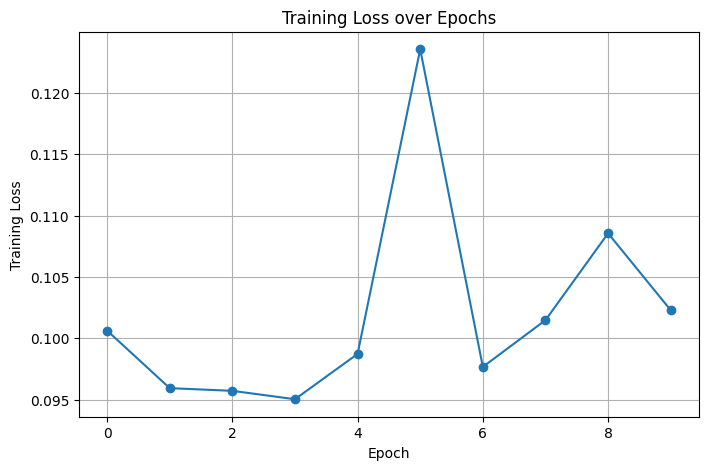

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()


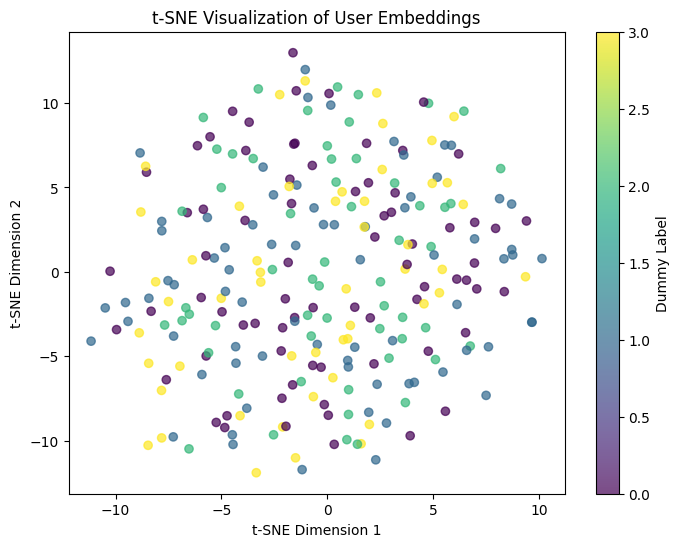

In [79]:
from sklearn.manifold import TSNE
import numpy as np

# Generate a dummy batch for visualization (simulate test data)
batch_size_vis = 256
self_feats_vis, neighbor_feats_vis, neighbor_link_feats_vis = generate_dummy_batch(batch_size_vis, 10, FEATURE_DIMS, LINK_FEATURE_DIM)
self_feats_vis = [x.to(device) for x in self_feats_vis]
neighbor_feats_vis = [x.to(device) for x in neighbor_feats_vis]
neighbor_link_feats_vis = neighbor_link_feats_vis.to(device)

# Get embeddings from the model
model.eval()
with torch.no_grad():
    embeddings, attn_weights = model(self_feats_vis, neighbor_feats_vis, neighbor_link_feats_vis)

# Convert embeddings to numpy
embeddings_np = embeddings.cpu().numpy()

# Apply t-SNE to reduce the embeddings to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Optionally, create dummy labels (or use real labels if available)
# Here, we assign random labels just for coloring
dummy_labels = np.random.randint(0, 4, size=embeddings_2d.shape[0])

# Plot the 2D t-SNE embeddings
plt.figure(figsize=(8,6))
scatter = plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=dummy_labels, cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of User Embeddings')
plt.colorbar(scatter, label='Dummy Label')
plt.show()


In [80]:
from sklearn.manifold import TSNE

In [81]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE


In [82]:
# For demonstration, we generate dummy embeddings for 100 users.
num_users = 100
embedding_dim = 32
dummy_embeddings = np.random.randn(num_users, embedding_dim)

# Optionally, you could use t-SNE to reduce the embeddings for visualization,
# but here we compute a similarity matrix directly on the original embeddings.
similarity_matrix = np.dot(dummy_embeddings, dummy_embeddings.T)


In [83]:
# Define a similarity threshold to decide when to add an edge.
# You may adjust this threshold based on your data.
similarity_threshold = 0.8

# Create an undirected graph.
G = nx.Graph()

# Add nodes for each user.
for i in range(num_users):
    G.add_node(i)

# Add edges between users with similarity above the threshold.
for i in range(num_users):
    for j in range(i+1, num_users):
        if similarity_matrix[i, j] > similarity_threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph has 100 nodes and 2138 edges.


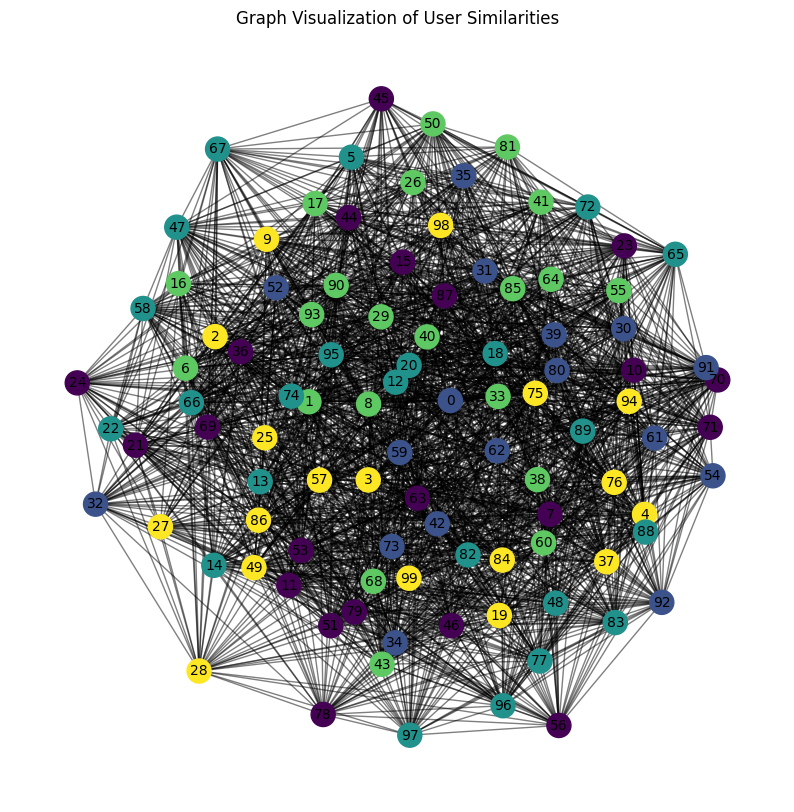

In [84]:
# Compute a layout for our nodes using the spring layout.
pos = nx.spring_layout(G, seed=42)  # seed for reproducibility

# Get a color for each node; for demonstration, we assign random colors.
node_colors = np.random.randint(0, 5, size=num_users)

plt.figure(figsize=(10, 10))
# Draw nodes with the computed positions.
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.cm.viridis, 
                       node_color=node_colors)

# Draw edges; you can use the edge weights to adjust thickness if desired.
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Graph Visualization of User Similarities')
plt.axis('off')
plt.show()
